<a href="https://colab.research.google.com/github/Tommy-Adisa/Explainable-Suicide-Risk-Detection-with-Transformers/blob/main/DELTA_IG_XAI_ROBERTa_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U kaleido

In [2]:
#!pip install transformers torch scikit-learn pandas numpy tqdm contractions captum wordcloud seaborn

In [3]:
!pip install -U \
transformers \
scikit-learn \
pandas \
numpy==1.26.4 \
tqdm \
contractions \
captum \
matplotlib \
seaborn \
wordcloud


In [4]:
#!pip uninstall -y torchvision
!pip install -U torchvision

Found existing installation: torchvision 0.25.0
Uninstalling torchvision-0.25.0:
  Successfully uninstalled torchvision-0.25.0
  Using cached torchvision-0.25.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
Using cached torchvision-0.25.0-cp312-cp312-manylinux_2_28_x86_64.whl (8.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.6 requires torch<2.10,>=1.10, but you have torch 2.10.0 which is incompatible.


In [5]:
from google.colab import drive
import nltk
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

BASE_DIR = "/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/roberta_explainability_outputs"
os.makedirs(BASE_DIR, exist_ok=True)

print("Saving outputs to:", BASE_DIR)


Saving outputs to: /content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/roberta_explainability_outputs


In [7]:
import numpy as np
import wordcloud
print("NumPy:", np.__version__)
print("WordCloud:", wordcloud.__version__)


NumPy: 1.26.4
WordCloud: 1.9.6


In [8]:
#!pip install wordcloud


In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
# The following import is failing due to dependency conflicts.
# Specifically, `torch` and `torchvision` versions are incompatible.
# You updated `torch` to 2.10.0, but `torchvision` (0.24.0) expects 2.9.0.
# To fix this, run the following commands in a *new cell* and then restart the runtime:
# !pip install -U torch==2.0.0 torchvision==0.15.0
# (or use versions compatible with your other packages, e.g., allow pip to resolve dependencies):
# !pip install -U transformers torch torchvision scikit-learn pandas numpy==1.26.4 tqdm contractions captum matplotlib seaborn wordcloud
# After running the above in a new cell, remember to go to Runtime -> Restart runtime.
from transformers import (
RobertaTokenizer, RobertaForSequenceClassification,
Trainer,
TrainingArguments
)
#from transformers import RobertaTokenizer, RobertaForSequenceClassification
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Load dataset
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/raw/Suicide_Detection.csv')
#df.head()

#print(df['class'].value_counts())
#print(len(df))

# Load dataset
df_all = pd.read_csv('/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/raw/Suicide_Detection.csv')
df_all.head()

print(df_all['class'].value_counts())
print(len(df_all))

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64
232074


#NOTE SECTION BELLOW

#INPUT HOW MANY SAMPLES IN THE DATASET YOU WANT TO USE AT THE TIME

In [14]:
df_all = df_all.drop_duplicates(subset='text')

N = 7000
df = df_all.groupby('class').sample(n=N, random_state=42).reset_index(drop=True)

df.to_csv("/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/reduced/suicide_data_small.csv", index=False)

print(df['class'].value_counts())
print(len(df))

class
non-suicide    7000
suicide        7000
Name: count, dtype: int64
14000


In [15]:


# Confirm dataset structure
print(df.columns)
print(df['class'].value_counts())
print(df.shape)
list(df.columns)

df = df[["text", "class"]]
label_map = {"non-suicide": 0, "suicide": 1}
df["label"] = df["class"].map(label_map)

#PRINT FIRTH 10
df.head(10)

Index(['Unnamed: 0', 'text', 'class'], dtype='str')
class
non-suicide    7000
suicide        7000
Name: count, dtype: int64
(14000, 3)


,text,class,label
0,Used to keep it cool Used to be a fool \n\nAll...,non-suicide,0
1,"Well, haven't mat a girl like this in a while ...",non-suicide,0
2,My girlfriend just left me👍👍👍👍👍😁😁😁😁😁 I don't w...,non-suicide,0
3,Some people really don't want an anthro gf I'm...,non-suicide,0
4,how to break up with someone who is very much ...,non-suicide,0
5,WHY ME Every time I send a message. Always in ...,non-suicide,0
6,Simba’s an ungrateful lil bitch Sings an entir...,non-suicide,0
7,"I will be completely honest, Binod binod binod...",non-suicide,0
8,"Anyone else not have any friends, but not real...",non-suicide,0
9,Disgusting and Suspicious Tea Today my dad had...,non-suicide,0


###THIS IS TO SPLIT THE DATASET BEFORE CLEANING.

“Minimal text preprocessing was applied to preserve linguistic and emotional cues essential for transformer-based models. Unlike traditional machine learning pipelines, aggressive text normalisation was avoided to ensure meaningful attention distributions and faithful Integrated Gradient attributions.”

When we clean before spliting, we let  information from test data influence training data

Cleaning before splitting, cause risk of:

Vocabulary leakage, Distribution leakage, Over-optimistic performance, Invalid explainability results

BERT was trained on raw, messy, natural language, including:

punctuation, repetition, emotional intensity, informal text, subwords, casing (for cased models). IF we remove too much hurts performance and explainability. Therfore, for safe cleaning and minimal cleaning, we will perform: Lowercasing,Removing URLs

Removing HTML tags

Expanding contractions

Removing emojis

In [16]:
import re
import contractions
from sklearn.model_selection import train_test_split

###Clean functions

In [17]:
def clean_contractions(text):
    try:
        return contractions.fix(text)
    except:
        return text  # fallback if contractions fails

def remove_html_tags_func(text):
    return re.sub(r'<.*?>', '', text)

def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA70-\U0001FAFF"
        u"\U0001F018-\U0001F270"
        u"\U0001F650-\U0001F67F"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

def clean_text_bert(text):
    text = str(text) if text else ""
    text = text.strip()
    if text == "":
        return ""
    text = clean_contractions(text)
    text = remove_html_tags_func(text)
    text = remove_url_func(text)
    text = remove_emoji(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

###Stratified Train-Test Split

In [18]:
train_df, val_df = train_test_split(
    df.copy(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

####Fill NaN & ensure strings

In [19]:
train_df['text'] = train_df['text'].fillna("").astype(str)
val_df['text']   = val_df['text'].fillna("").astype(str)

####Apply Cleaning

In [20]:
train_df['clean_text'] = train_df['text'].apply(clean_text_bert)
val_df['clean_text']   = val_df['text'].apply(clean_text_bert)

In [21]:
# Sample 5 random rows from each class
sample_class_1 = train_df[train_df['label'] == 1].sample(5, random_state=42)
sample_class_0 = train_df[train_df['label'] == 0].sample(5, random_state=42)

# Combine them and reset index
sample_train_df = pd.concat([sample_class_1, sample_class_0]).reset_index(drop=True)

# Display only the columns you want, like with head()
sample_train_df[[ 'text', 'clean_text', 'class', 'label']]

,text,clean_text,class,label
0,I swear.I swear to any God with everything I h...,i swear.i swear to any god with everything i h...,suicide,1
1,"Laugh and the world laughs with you, weep and ...","laugh and the world laughs with you, weep and ...",suicide,1
2,RantI feel like my life is a nightmare and I b...,ranti feel like my life is a nightmare and i b...,suicide,1
3,I am going to kill myself tonightI wrote my le...,i am going to kill myself tonighti wrote my le...,suicide,1
4,12 and I really need some help.I am 12 years o...,12 and i really need some help.i am 12 years o...,suicide,1
5,i feel like dying brr anyone wanna push me ove...,i feel like dying brr anyone want to push me o...,non-suicide,0
6,"No one gives a fuck if you ""accidentally"" sele...","no one gives a fuck if you ""accidentally"" sele...",non-suicide,0
7,"Day 1 of alphabet: A A is a vowel, a letter in...","day 1 of alphabet: a a is a vowel, a letter in...",non-suicide,0
8,Dear lord save me Someone just asked if she co...,dear lord save me someone just asked if she co...,non-suicide,0
9,Any tips on maintaining a friendship? I met th...,any tips on maintaining a friendship? i met th...,non-suicide,0


###Extract lists for tokenization

In [22]:
train_texts  = train_df['clean_text'].tolist()
train_labels = train_df['label'].tolist()

val_texts    = val_df['clean_text'].tolist()
val_labels   = val_df['label'].tolist()


###Tokenize with Hugging Face BertTokenizer

In [23]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

###Dataset Wrapper

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer

####This is to Define batch size and device. We will use the approach of effective batch size batch_size = 8, gradient_accumulation_steps = 2, Effective batch size = 8 * 2 = 16. The optimizer will only update weights after accumulating gradients over 2 batches, effectively mimicking a batch of 16.

In [25]:
batch_size = 8
gradient_accumulation_steps = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


##Prepare Tokenizers and datasets

In [27]:

# Create Dataset objects
train_dataset = TokenizedDataset(train_encodings, train_labels)
val_dataset   = TokenizedDataset(val_encodings, val_labels)

###This is to Wrap into DataLoader for training

In [28]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)


In [29]:
batch = next(iter(train_loader))
print("input_ids:", batch['input_ids'].shape)        # [batch_size, max_len]
print("attention_mask:", batch['attention_mask'].shape)
print("labels:", batch['labels'].shape)


input_ids: torch.Size([8, 128])
attention_mask: torch.Size([8, 128])
labels: torch.Size([8])


/tmp/ipython-input-1191073609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


###Difine model

In [30]:
from transformers import RobertaForSequenceClassification


num_labels = 2  # binary classification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_labels ,
    output_attentions=True
)

model.to(device)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [31]:
#from transformers import RobertaForSequenceClassification


#num_labels = 2  # binary classification

#model = RobertaForSequenceClassification.from_pretrained(
 #   "roberta-base",
  #  num_labels=num_labels ,
   # output_attentions=True
#)

#model.to(device)


####This is to difine the optimizer

In [32]:
from torch.optim import AdamW


optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)


In [33]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = len(train_loader) * epochs // gradient_accumulation_steps

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [34]:
print(next(model.parameters()).device)


cuda:0


In [35]:
from tqdm import tqdm

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    loop = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch+1}",
        leave=True
    )

    optimizer.zero_grad()

    for step, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        #  tqdm live update
        loop.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished. Average loss: {avg_loss:.4f}")


Epoch 1:   0%|          | 0/1400 [00:00<?, ?it/s]/tmp/ipython-input-1191073609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 1400/1400 [04:28<00:00,  5.21it/s, loss=0.0192]


Epoch 1 finished. Average loss: 0.1872


Epoch 2: 100%|██████████| 1400/1400 [04:13<00:00,  5.52it/s, loss=0.0010]


Epoch 2 finished. Average loss: 0.0426


Epoch 3: 100%|██████████| 1400/1400 [04:13<00:00,  5.53it/s, loss=0.0005]

Epoch 3 finished. Average loss: 0.0150


#EVALUATION OF ROBERTa#
##1. Confusion matrix 2. Precision, recall, F1 3. Classification report 4. Store correctly predicted suicide samples 5. Store correctly predicted non-suicide samples

In [36]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)

model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [37]:
all_preds = []
all_labels = []

correct_suicide_samples = []
correct_nonsuicide_samples = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=True):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store correctly predicted samples
        for i in range(len(labels)):
            if preds[i] == labels[i]:
                if labels[i].item() == 1:
                    correct_suicide_samples.append(input_ids[i].cpu())
                else:
                    correct_nonsuicide_samples.append(input_ids[i].cpu())


Evaluating:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipython-input-1191073609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 350/350 [00:19<00:00, 17.90it/s]


##CONFUSION MATRIX

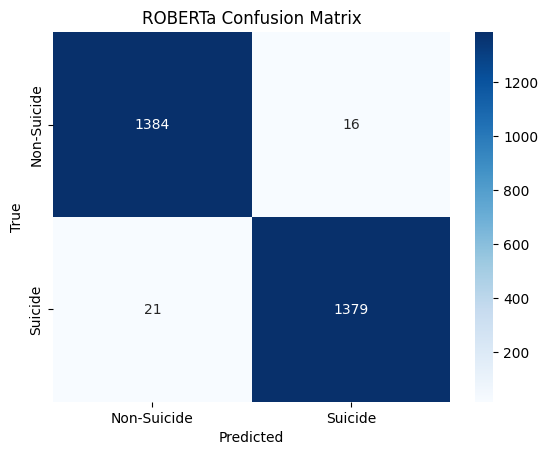

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Suicide', 'Suicide'],
            yticklabels=['Non-Suicide', 'Suicide'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ROBERTa Confusion Matrix')
plt.show()


#Precision, Recall, F1

In [39]:
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average='binary'
)

print(f"ROBERTa_Precision: {precision:.4f}")
print(f"ROBERTa_Recall:    {recall:.4f}")
print(f"ROBERTa_F1-score:  {f1:.4f}")


ROBERTa_Precision: 0.9885
ROBERTa_Recall:    0.9850
ROBERTa_F1-score:  0.9868


In [40]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=['Non-Suicide', 'Suicide']
    )
)


              precision    recall  f1-score   support

 Non-Suicide       0.99      0.99      0.99      1400
     Suicide       0.99      0.98      0.99      1400

    accuracy                           0.99      2800
   macro avg       0.99      0.99      0.99      2800
weighted avg       0.99      0.99      0.99      2800



In [41]:
def decode_samples(token_ids, tokenizer, max_samples=50):
    texts = []
    for ids in token_ids[:max_samples]:
        text = tokenizer.decode(ids, skip_special_tokens=True)
        texts.append(text)
    return texts


In [42]:
correct_suicide_texts = decode_samples(
    correct_suicide_samples,
    tokenizer
)

correct_nonsuicide_texts = decode_samples(
    correct_nonsuicide_samples,
    tokenizer
)


In [43]:
import pandas as pd

pd.DataFrame({'text': correct_suicide_texts}).to_csv(
    "/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/correct_suicide_samples_roberta.csv", index=False
)

pd.DataFrame({'text': correct_nonsuicide_texts}).to_csv(
    '/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/correct_nonsuicide_samples_roberta.csv', index=False
)


#EXPLAINABILITY AI ATTENTION + INTEGRATED GRADIENT

#NOTE

### What attention shows
##Attention answers: “Which words did ROBERTa focus on when forming its internal representation?”
In practice:
•	Attention scores show token-to-token influence
•	They highlight contextual importance
•	They are model-internal signals, not causal proofs

###Important limitation
##Attention ≠ Explanation by itself
This is a known research conclusion:
•	High attention ≠ high importance

##Attention shows where the model looks, not why the output changes
 So attention alone is insufficient for explainability


##TASK TO DO NEXT
####combine attention mechanisms and Integrated Gradients to identify both model focus and causal word-level contributions, highlighting their alignment and divergence”

###Select sample from sucide

####Tokinize the sample

In [44]:
#pick a sample
sample_text = correct_suicide_texts[8]

inputs = tokenizer(
    sample_text,
    return_tensors='pt',
    truncation=True,
    max_length=128
).to(device)


###Forward pass with attention extraction

In [45]:
model.eval()

with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions


###Aggregate attention

In [46]:
import torch

# Average heads first → shape: (layers, tokens, tokens)
layer_attentions = torch.stack([layer.mean(dim=1).squeeze(0) for layer in attentions])

# Average across layers → overall attention
avg_attention = layer_attentions.mean(dim=0)  # shape: (tokens, tokens)

# CLS token attention to all tokens
cls_attention = avg_attention[0]  # shape: (tokens,)


####Merge WordPiece tokens into words

In [47]:
def merge_wordpieces(tokens, attention_scores):
    words = []
    word_scores = []

    current_word = ''
    current_score = 0.0
    count = 0

    for token, score in zip(tokens, attention_scores):
        if token.startswith('##'):
            current_word += token[2:]
            current_score += score
            count += 1
        else:
            if current_word != '':
                words.append(current_word)
                word_scores.append(current_score / count)
            current_word = token
            current_score = score
            count = 1

    # Append last word
    words.append(current_word)
    word_scores.append(current_score / count)

    return words, torch.tensor(word_scores)


In [48]:
tokens_raw = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Clean tokens
tokens = [t.replace("Ġ", "") for t in tokens_raw]


words, word_attention = merge_wordpieces(tokens, cls_attention.cpu())


###Heatmap of attention across tokens

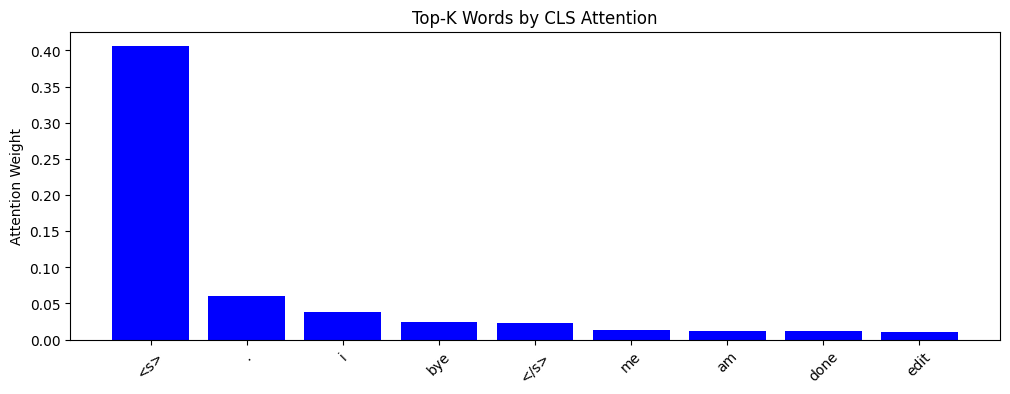

In [49]:
import numpy as np
import matplotlib.pyplot as plt

top_k = 15
top_indices = np.argsort(word_attention.numpy())[::-1][:top_k]
top_words = [words[i] for i in top_indices]

# Fix negative-stride issue
word_attention_np = word_attention.numpy()
top_values = word_attention_np[top_indices]

plt.figure(figsize=(12,4))
plt.bar(top_words, top_values, color='blue')
plt.xticks(rotation=45)
plt.ylabel("Attention Weight")
plt.title("Top-K Words by CLS Attention")
plt.show()


In [50]:
word_attention_np = word_attention.numpy()
top_values = word_attention_np[top_indices]


In [51]:
from matplotlib import cm
from IPython.core.display import display, HTML

def highlight_text(words, attention_scores):
    # Normalize
    scores = (attention_scores - attention_scores.min()) / (attention_scores.max() - attention_scores.min())
    cmap = cm.get_cmap('Reds')
    html = ''
    for word, score in zip(words, scores):
        color = cm.colors.to_hex(cmap(score))
        html += f'<span style="background-color:{color}">{word} </span>'
    return html

html = highlight_text(words, word_attention)
display(HTML(html))


/tmp/ipython-input-2452023492.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


In [52]:
cls_numpy = cls_attention.cpu().numpy()
top_values = cls_numpy[top_indices]


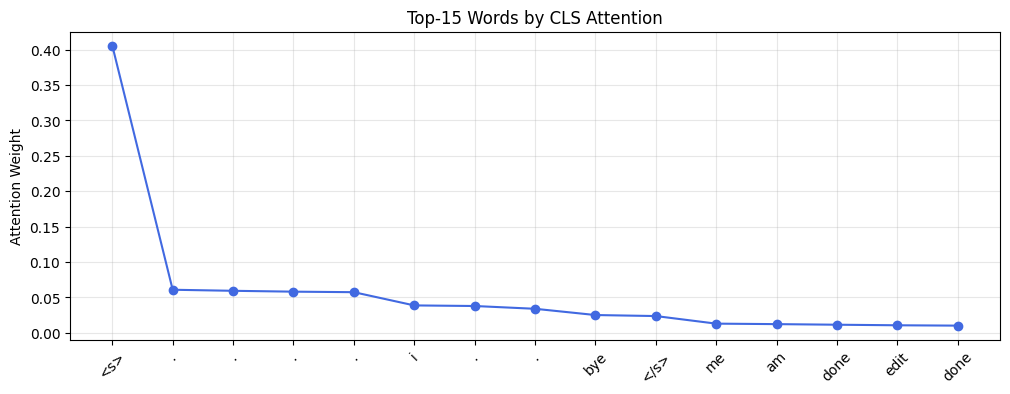

In [53]:
import numpy as np
import matplotlib.pyplot as plt

top_k = 15

# Convert to NumPy and fix negative-stride issues
word_attention_np = word_attention.numpy()

# Get top-K indices
top_indices = np.argsort(word_attention_np)[::-1][:top_k]

# Get top-K words and their attention scores
top_words = [words[i] for i in top_indices]
top_values = word_attention_np[top_indices]

# Plot like the first style (line plot with markers)
plt.figure(figsize=(12,4))
plt.plot(top_values, marker='o', linestyle='-', color='royalblue')
plt.xticks(range(top_k), top_words, rotation=45)
plt.ylabel("Attention Weight")
plt.title(f"Top-{top_k} Words by CLS Attention")
plt.grid(alpha=0.3)
plt.show()


In [54]:
#token_importance = list(zip(tokens, cls_attention.cpu().numpy()))

# Sort by importance
#token_importance = sorted(token_importance, key=lambda x: x[1], reverse=True)

#for token, score in token_importance[:10]:
 #   print(f"{token}: {score:.4f}")


In [55]:
attention_token_scores = list(
    zip(tokens, cls_attention.cpu().numpy())
)
attention_token_scores = sorted(
    attention_token_scores,
    key=lambda x: x[1],
    reverse=True
)

for token, score in attention_token_scores[:10]:
    print(f"{token}: {score:.4f}")



<s>: 0.4057
.: 0.0608
.: 0.0593
.: 0.0581
.: 0.0573
i: 0.0386
.: 0.0378
.: 0.0339
bye: 0.0250
</s>: 0.0236


In [56]:
combined_attention = torch.zeros_like(attentions[0][0][0])

for layer in attentions:
    for head in layer[0]:
        combined_attention += head

combined_attention /= (len(attentions) * layer.shape[1])

cls_combined = combined_attention[0]
cls_combined /= cls_combined.sum()


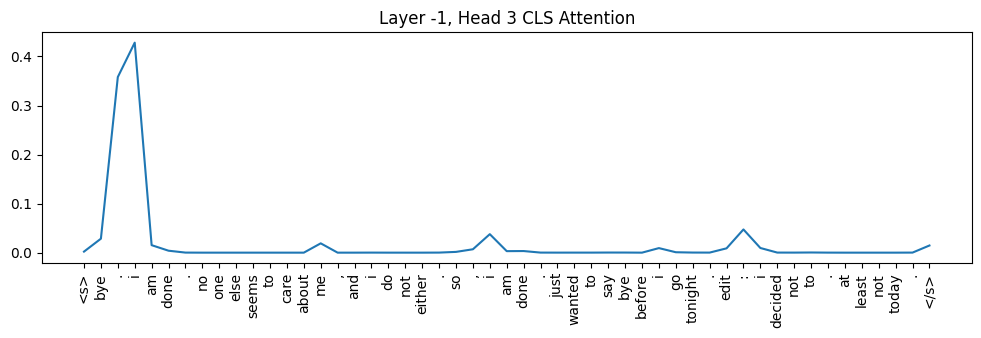

In [57]:
layer = -1
head = 3

head_attention = attentions[layer][0, head, 0].detach().cpu().numpy()

plt.figure(figsize=(12,3))
plt.plot(head_attention)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title(f"Layer {layer}, Head {head} CLS Attention")
plt.show()


###“Attention visualisation showed dominant focus on special tokens ([CLS], [SEP]) with diffuse distribution across content words. This supports prior findings that attention weights do not reliably correspond to feature importance. Therefore, Integrated Gradients were employed for faithful attribution.”

#INTEGRATED GRADIENTS

In [58]:
import torch
import numpy as np
from captum.attr import IntegratedGradients
from collections import defaultdict

In [59]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
).to(device)

model.eval()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

###IG inpute

In [60]:
def prepare_ig_inputs(input_ids, tokenizer):
    """
    Creates attention mask and PAD baseline IDs for IG.
    """
    attention_mask = (input_ids != tokenizer.pad_token_id).long()

    baseline_ids = torch.full_like(
        input_ids,
        tokenizer.pad_token_id
    )

    return attention_mask, baseline_ids


###Get RoBERTa Embeddings

In [61]:
def get_roberta_embeddings(model, input_ids):
    """
    Returns RoBERTa token embeddings for IG.
    """
    return model.roberta.embeddings(input_ids)


###Forward Function

In [62]:
def forward_func_roberta(embeddings, attention_mask):
    outputs = model.roberta(
        inputs_embeds=embeddings,
        attention_mask=attention_mask
    )

    # IMPORTANT: pass full hidden states
    logits = model.classifier(outputs.last_hidden_state)

    return logits


###Run Integrated Gradients

In [63]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(forward_func_roberta)

# Pick ONE correctly predicted suicide sample
sample_ids = correct_suicide_samples[0].unsqueeze(0).to(device)

# Prepare inputs
attention_mask, baseline_ids = prepare_ig_inputs(sample_ids, tokenizer)

# Embeddings
input_embeddings = get_roberta_embeddings(model, sample_ids)
baseline_embeddings = get_roberta_embeddings(model, baseline_ids)

input_embeddings.requires_grad_(True)

# IG attribution
attributions, delta = ig.attribute(
    inputs=input_embeddings,
    baselines=baseline_embeddings,
    additional_forward_args=(attention_mask,),
    target=1,  # suicide class
    return_convergence_delta=True
)

print("Attributions shape:", attributions.shape)
print("Convergence delta:", delta.item())


Attributions shape: torch.Size([1, 128, 768])
Convergence delta: -0.03533976152539253


In [64]:
def save_delta_stats(deltas, filename_prefix="ig_deltas"):
    import numpy as np

    stats = {
        "mean": float(np.mean(deltas)),
        "std": float(np.std(deltas)),
        "min": float(np.min(deltas)),
        "max": float(np.max(deltas)),
        "count": len(deltas),
    }

    text = "\n".join([f"{k}: {v}" for k, v in stats.items()])
    save_text_output(text, filename_prefix)


###Token-Level Attribution

###Token cleaning function

In [65]:
import string
import numpy as np
def clean_roberta_token_keep_boundary(token):
    if token in ["<s>", "</s>", "<pad>"]:
        return ""
    if all(char in string.punctuation for char in token.replace("Ġ", "")):
        return ""
    return token


In [66]:
roberta_tokens = tokenizer.convert_ids_to_tokens(
    sample_ids.squeeze(0)
)


In [67]:
roberta_ig_scores = (
    attributions
    .sum(dim=-1)
    .squeeze(0)
    .detach()
    .cpu()
    .numpy()
)


###Merge subwords into words

In [68]:
def merge_roberta_subwords(tokens, scores):
    merged_tokens = []
    merged_scores = []

    current_word = None
    current_score = 0.0

    for tok, score in zip(tokens, scores):

        if tok in ["<s>", "</s>", "<pad>"]:
            continue

        if tok.startswith("Ġ"):
            if current_word is not None:
                merged_tokens.append(current_word)
                merged_scores.append(current_score)

            current_word = tok[1:]
            current_score = float(score)

        else:
            if current_word is None:
                continue
            current_word += tok
            current_score += float(score)

    if current_word is not None:
        merged_tokens.append(current_word)
        merged_scores.append(current_score)

    return merged_tokens, merged_scores


#####RoBERTa subword attributions were aggregated to word-level importance by detecting word boundaries via the Ġ prefix and summing subword attributions accordingly.

###This is to Build token–IG table

In [69]:
token_importance = attributions.sum(dim=-1).squeeze(0)
token_importance = token_importance.detach().cpu()

print(token_importance.dtype)
print(token_importance.shape)


torch.float32
torch.Size([128])


In [70]:
# Clean tokens but KEEP Ġ
#clean_tokens = [clean_roberta_token_keep_boundary(t) for t in tokens]

# Ensure scores are numpy
#scores = (
 #   token_importance.detach().cpu().numpy()
  #  if torch.is_tensor(token_importance)
   # else token_importance
#)

# Ensure scores are a clean 1D float array
#if torch.is_tensor(token_importance):
 #   scores = token_importance.detach().cpu().numpy()
#else:
 #   scores = np.array(token_importance)

# Force numeric + flatten
#scores = np.asarray(scores, dtype=np.float32).reshape(-1)

# Safety check
#assert len(scores) == len(tokens), "Mismatch between tokens and scores"



In [71]:
# Clean tokens but KEEP Ġ
clean_tokens = [clean_roberta_token_keep_boundary(t) for t in tokens]


# Token-level IG
token_importance = attributions.sum(dim=-1).squeeze(0)
token_importance = token_importance.detach().cpu()

# Convert to numpy
scores = token_importance.numpy()

# Get tokens aligned with IG
input_ids = sample_ids.squeeze(0)[:len(scores)]
roberta_tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Safety check
#assert len(tokens) == len(scores)


In [72]:
print(type(scores), scores.shape)
print(type(scores[0]), scores[0])


<class 'numpy.ndarray'> (128,)
<class 'numpy.float32'> -0.017650083


In [73]:
merged_tokens, merged_scores = merge_roberta_subwords(
    roberta_tokens,
    roberta_ig_scores
)

df_words = pd.DataFrame({
    "token": merged_tokens,
    "ig_score": merged_scores
})

df_words["abs_ig"] = df_words["ig_score"].abs()


In [74]:
#from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#df_words = df_words[~df_words["token"].isin(ENGLISH_STOP_WORDS)]


###Sort and Select top 20

In [75]:
top20_clean = (
    df_words
    .sort_values("abs_ig", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

top20_clean.index += 1

print("\nTop-20 IG Words (RoBERTa — Cleaned & Merged):\n")
for i, row in top20_clean.iterrows():
    print(
        f"{i:>2}. {row.token:<20} "
        f"IG={row.ig_score:+.4f} | |IG|={row.abs_ig:.4f}"
    )



Top-20 IG Words (RoBERTa — Cleaned & Merged):

 1. i                    IG=-0.0328 | |IG|=0.0328
 2. to                   IG=-0.0291 | |IG|=0.0291
 3. i                    IG=-0.0281 | |IG|=0.0281
 4. was                  IG=-0.0243 | |IG|=0.0243
 5. females              IG=-0.0161 | |IG|=0.0161
 6. i                    IG=+0.0096 | |IG|=0.0096
 7. i                    IG=+0.0089 | |IG|=0.0089
 8. did                  IG=+0.0073 | |IG|=0.0073
 9. the                  IG=+0.0072 | |IG|=0.0072
10. treated              IG=+0.0066 | |IG|=0.0066
11. a                    IG=-0.0064 | |IG|=0.0064
12. the                  IG=-0.0061 | |IG|=0.0061
13. anxiety              IG=+0.0060 | |IG|=0.0060
14. i                    IG=+0.0053 | |IG|=0.0053
15. of                   IG=+0.0045 | |IG|=0.0045
16. it                   IG=-0.0041 | |IG|=0.0041
17. and                  IG=-0.0040 | |IG|=0.0040
18. gentler              IG=+0.0040 | |IG|=0.0040
19. unfriendly           IG=-0.0036 | |IG|=0.0036
20

In [76]:
def save_dataframe(df, filename_prefix):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = f"{BASE_DIR}/{filename_prefix}_{timestamp}.csv"
    df.to_csv(filepath, index=False)
    print(f"Saved to {filepath}")


In [77]:
def save_wordcloud(wc, filename_prefix):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = f"{BASE_DIR}/{filename_prefix}_{timestamp}.png"
    wc.to_file(filepath)
    print(f"Saved to {filepath}")


In [78]:
from datetime import datetime

def save_text_output(text, filename_prefix):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = f"{BASE_DIR}/{filename_prefix}_{timestamp}.txt"
    with open(filepath, "w") as f:
        f.write(text)
    print(f"Saved to {filepath}")


##Multiline Integrated Gradients heatmap for RoBERTa

###This is to Prepare token-level IG scores

In [79]:
# Sum across embedding dimension
token_importance = attributions.sum(dim=-1).squeeze(0)

# Detach & move to CPU
token_importance = token_importance.detach().cpu().numpy()

# Convert token IDs → tokens
roberta_tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))



###Clean tokens for RoBERTa heatmap

In [80]:
import string

def clean_roberta_token_for_heatmap(token):
    if token in ["<s>", "</s>", "<pad>"]:
        return ""
    token = token.replace("Ġ", "")  # remove space marker
    if token == "":
        return ""
    if all(char in string.punctuation for char in token):
        return ""
    return token


In [81]:
clean_tokens = [clean_roberta_token_for_heatmap(t) for t in tokens]


###Multiline IG heatmap

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import math

def visualize_token_heatmap_multiline(
    tokens,
    scores,
    title="Integrated Gradients Heatmap (RoBERTa)",
    tokens_per_row=20
):
    # Filter empty tokens
    filtered = [(t, s) for t, s in zip(tokens, scores) if t != ""]
    tokens, scores = zip(*filtered)

    scores = np.array(scores)

    # Normalize scores for color intensity
    scores_norm = scores / (np.max(np.abs(scores)) + 1e-8)

    num_tokens = len(tokens)
    num_rows = math.ceil(num_tokens / tokens_per_row)

    # Pad tokens and scores
    pad_len = num_rows * tokens_per_row - num_tokens
    tokens_padded = list(tokens) + [""] * pad_len
    scores_padded = np.pad(scores_norm, (0, pad_len), constant_values=0)

    token_matrix = np.array(tokens_padded).reshape(num_rows, tokens_per_row)
    score_matrix = scores_padded.reshape(num_rows, tokens_per_row)

    # Plot
    plt.figure(figsize=(tokens_per_row * 0.6, num_rows * 0.6))
    im = plt.imshow(score_matrix, cmap="RdBu_r", aspect="auto", vmin=-1, vmax=1)

    for i in range(num_rows):
        for j in range(tokens_per_row):
            tok = token_matrix[i, j]
            if tok != "":
                plt.text(j, i, tok, ha="center", va="center", fontsize=10)

    plt.xticks([])
    plt.yticks([])
    plt.colorbar(im, fraction=0.02, pad=0.02, label="Normalized IG score")
    plt.title(title)
    plt.tight_layout()
    plt.show()


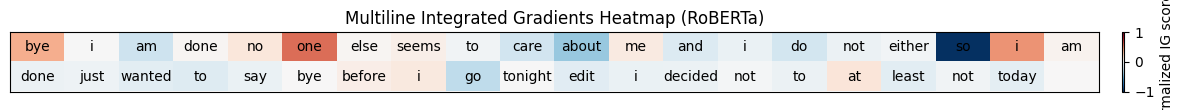

In [83]:
visualize_token_heatmap_multiline(
    clean_tokens,
    token_importance,
    title="Multiline Integrated Gradients Heatmap (RoBERTa)",
    tokens_per_row=20
)


#####Token-level attributions were visualized using a multiline heatmap, where Integrated Gradients scores were summed across the embedding dimension and normalized for visual comparison.”

####RoBERTa subword merging

In [84]:
def merge_roberta_tokens(tokens, scores):
    merged_tokens = []
    merged_scores = []

    current_word = ""
    current_score = 0.0

    for tok, score in zip(tokens, scores):
        if tok in ["<s>", "</s>", "<pad>"]:
            continue

        if tok.startswith("Ġ"):
            # New word
            if current_word:
                merged_tokens.append(current_word)
                merged_scores.append(current_score)
            current_word = tok[1:]   # remove Ġ
            current_score = score
        else:
            # Continuation subword
            current_word += tok
            current_score += score

    if current_word:
        merged_tokens.append(current_word)
        merged_scores.append(current_score)

    return merged_tokens, merged_scores


####Stopwords

In [85]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from collections import defaultdict

STOPWORDS = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###This is to Collect IG word scores

In [86]:
from collections import defaultdict
from captum.attr import IntegratedGradients
import torch

def collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_samples,
    target_class,
    max_samples=1000
):
    model.eval()

    word_scores = defaultdict(float)
    word_counts = defaultdict(int)

    ig = IntegratedGradients(forward_func_roberta)

    for sample_ids in correct_samples[:max_samples]:
        sample_ids = sample_ids.unsqueeze(0).to(device)

        attention_mask = (sample_ids != tokenizer.pad_token_id).long()

        baseline_ids = torch.full_like(
            sample_ids, tokenizer.pad_token_id
        ).to(device)

        # Embeddings
        input_embeds = model.roberta.embeddings(sample_ids)
        baseline_embeds = model.roberta.embeddings(baseline_ids)
        input_embeds.requires_grad_(True)

        # Integrated Gradients
        #attributions, _ = ig.attribute(
        attributions, delta = ig.attribute(
            inputs=input_embeds,
            baselines=baseline_embeds,
            additional_forward_args=(attention_mask,),
            target=target_class,
            return_convergence_delta=True
        )

        # Filter unreliable explanations
        kept, skipped = 0, 0

        if abs(delta.item()) <= 0.05:
            kept += 1
        else:
            skipped += 1
            continue

        # Token-level IG
        token_importance = attributions.sum(dim=-1).squeeze(0)
        token_importance = token_importance / torch.norm(token_importance)

        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))

        words, scores = merge_roberta_subwords(
            tokens,
            token_importance.detach().cpu().numpy()
        )

        for w, s in zip(words, scores):
            w = w.lower()
            if len(w) < 3 or not w.isalpha():
                continue

            if s > 0:  # positive IG for suicide class
                word_scores[w] += s
                word_counts[w] += 1

    mean_word_scores = {
        w: word_scores[w] / word_counts[w]
        for w in word_scores
        if word_counts[w] >= 2
    }

    return mean_word_scores
    print(f"IG kept: {kept}, skipped (high delta): {skipped}")



In [87]:
#print(f"IG kept: {kept}, skipped (high delta): {skipped}")


###Word Cloud

In [88]:
#import numpy as np

# PATCH numpy.asarray to ignore `copy`
#_old_asarray = np.asarray
#def _patched_asarray(a, *args, **kwargs):
 #   kwargs.pop("copy", None)
  #  return _old_asarray(a, *args, **kwargs)

#np.asarray = _patched_asarray


In [89]:
#from wordcloud import WordCloud
#import matplotlib.pyplot as plt

#def plot_ig_wordcloud(word_scores, title):
 #   wc = WordCloud(
  #      width=1000,
   #     height=400,
    #    background_color="white",
     #   colormap="Reds",
      #  max_words=100
    #).generate_from_frequencies(word_scores)

    #plt.figure(figsize=(14, 5))
    #plt.imshow(wc, interpolation="bilinear")
    #plt.axis("off")
    #plt.title(title, fontsize=16)
    #plt.show()


In [90]:
word_scores = (
    df_words[df_words["ig_score"] > 0]
    .groupby("token")["ig_score"]
    .sum()
    .to_dict()
)

#word_scores = {
 #   w: s for w, s in word_scores.items()
  #  if w not in STOPWORDS and s > 0.01 and len(w) > 2
#}


In [91]:
#from wordcloud import WordCloud
#import matplotlib.pyplot as plt


#def plot_ig_wordcloud(word_scores, title):
 #   wc = WordCloud(
  #      width=1000,
   #     height=400,
    #    background_color="white",
     #   colormap="Reds",
      #  max_words=100
   # ).generate_from_frequencies(word_scores)

 #   plt.figure(figsize=(14, 5))
    #plt.imshow(wc, interpolation="bilinear")
  #  plt.imshow(wc.to_image())
   # plt.axis("off")
   # plt.title(title, fontsize=16)
    #plt.show()


In [92]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime

def plot_ig_wordcloud(
    word_scores,
    title,
    filename,
    save_dir="/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/roberta_explainability_outputs"
):
    wc = WordCloud(
        width=1000,
        height=400,
        background_color="white",
        colormap="Reds",
        max_words=100
    ).generate_from_frequencies(word_scores)

    # ---- DISPLAY ----
    plt.figure(figsize=(14, 5))
    plt.imshow(wc.to_image())
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

    # ---- SAVE ----
    import os
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{save_dir}/{filename}_{timestamp}.png"
    wc.to_file(save_path)

    print(f" WordCloud saved to: {save_path}")

###Roberta Sucide class

In [93]:

#print("NumPy:", np.__version__)
#print("WordCloud:", wordcloud.__version__)


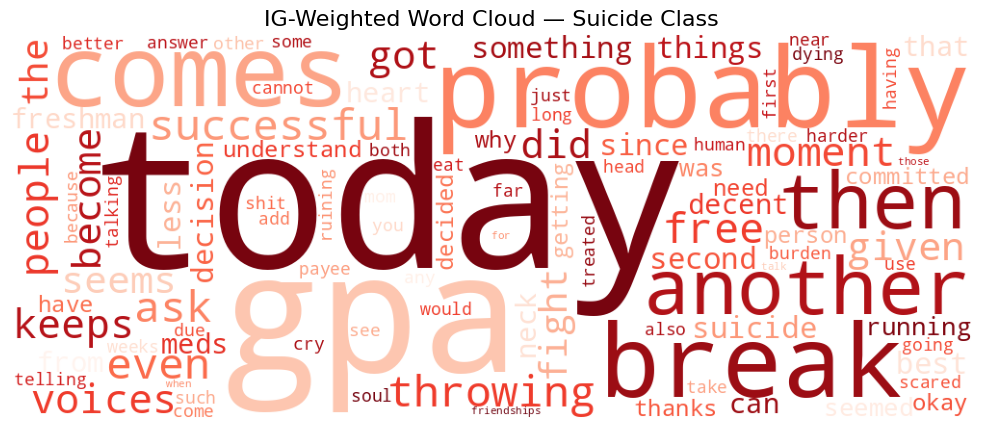

 WordCloud saved to: /content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/roberta_explainability_outputs/ig_RoBERTa_wordcloud_suicide_20260123_190154.png


In [94]:
suicide_word_scores = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_suicide_samples,
    target_class=1,
    max_samples=200
)

plot_ig_wordcloud(
    suicide_word_scores,
    title="IG-Weighted Word Cloud — Suicide Class",
    filename="ig_RoBERTa_wordcloud_suicide"
)
#plot_ig_wordcloud(
 #   word_scores,
  #  title="IG-Weighted Word Cloud — Suicide Class"
#)



###Non-Suicide Word Cloud

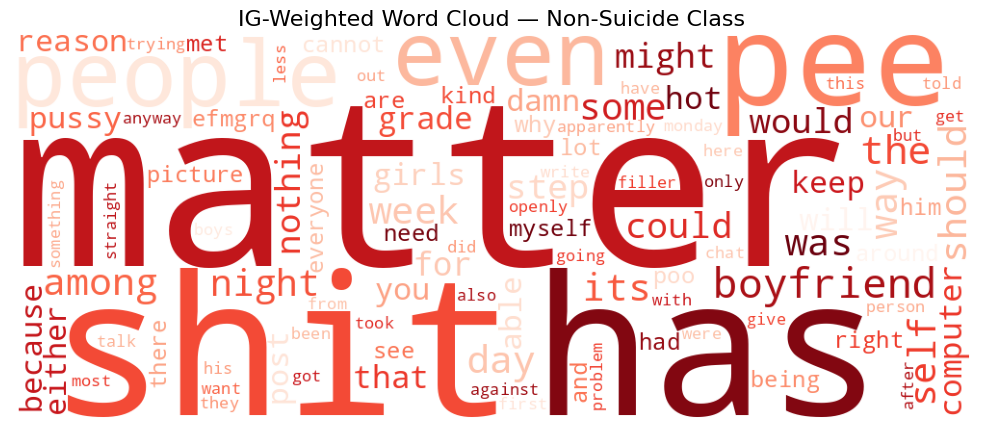

 WordCloud saved to: /content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/roberta_explainability_outputs/ig_RoBERTa_wordcloud_nonsuicide_20260123_190401.png


In [95]:
nonsuicide_word_scores_roberta = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_nonsuicide_samples,
    target_class=0,
    max_samples=200
)

plot_ig_wordcloud(
    nonsuicide_word_scores_roberta,
    title="IG-Weighted Word Cloud — Non-Suicide Class",
    filename="ig_RoBERTa_wordcloud_nonsuicide"
)


##CONTRASTIVE INTEGRATED GRADIENTS (Suicide − Non-Suicide)

#####IGcontrast​(w)=E[IG(w∣Suicide)]−E[IG(w∣Non-Suicide)]

###Contrastive IG collector

In [96]:


def clean_roberta_token(token):
    token = token.replace("Ġ", "")
    if token in ["<s>", "</s>", "<pad>"]:
        return ""
    if all(c in string.punctuation for c in token):
        return ""
    return token.lower()


def collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_samples,
    target_class,
    max_samples=500,
    device="cuda"
):
    model.eval()
    ig = IntegratedGradients(forward_func_roberta)

    word_scores = defaultdict(float)
    word_counts = defaultdict(int)

    for sample_ids in correct_samples[:max_samples]:
        sample_ids = sample_ids.unsqueeze(0).to(device)
        attention_mask = (sample_ids != tokenizer.pad_token_id).long()

        baseline_ids = torch.full_like(
            sample_ids, tokenizer.pad_token_id
        ).to(device)

        input_embeds = model.roberta.embeddings(sample_ids)
        baseline_embeds = model.roberta.embeddings(baseline_ids)
        input_embeds.requires_grad_(True)

        attributions = ig.attribute(
            inputs=input_embeds,
            baselines=baseline_embeds,
            additional_forward_args=(attention_mask,),
            target=target_class
        )

        token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))

        for tok, score in zip(tokens, token_scores):
            tok = clean_roberta_token(tok)
            if tok == "" or len(tok) < 3:
                continue

            word_scores[tok] += score
            word_counts[tok] += 1

    # Average IG per word
    avg_word_scores = {
        w: word_scores[w] / word_counts[w]
        for w in word_scores
        if word_counts[w] >= 2
    }

    return avg_word_scores


###Compute contrastive IG

In [97]:
suicide_ig = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_suicide_samples,
    target_class=1,
    max_samples=200
)

nonsuicide_ig = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_nonsuicide_samples,
    target_class=0,
    max_samples=200
)

contrastive_ig = {
    w: suicide_ig[w] - nonsuicide_ig.get(w, 0.0)
    for w in suicide_ig
    if (suicide_ig[w] - nonsuicide_ig.get(w, 0.0)) > 0
}


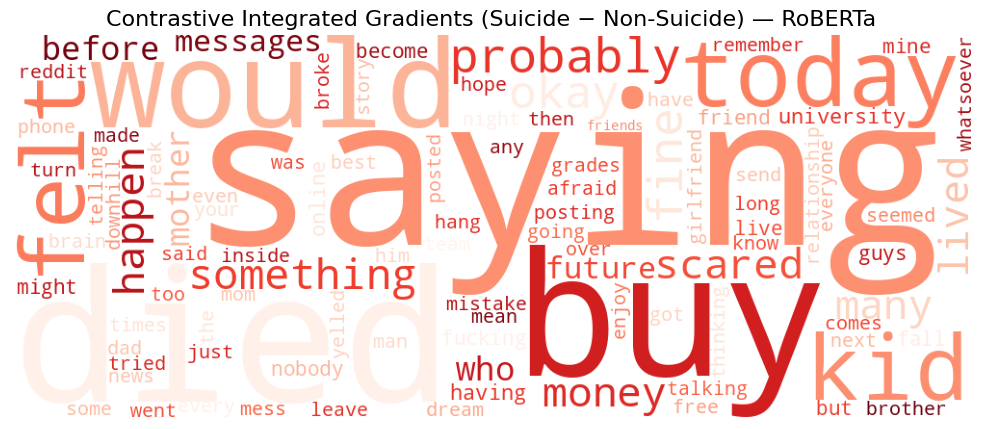

 WordCloud saved to: /content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/roberta_explainability_outputs/contrastive_suicide_nonsuicide_20260123_190809.png


In [98]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    width=1400,
    height=500,
    background_color="white",
    colormap="Reds",
    max_words=100
).generate_from_frequencies(contrastive_ig)

# Removed manual plotting and call to problematic save_wordcloud.
# Using plot_ig_wordcloud from wu04hyt200te which handles both display and saving.
plot_ig_wordcloud(
    contrastive_ig,
    title="Contrastive Integrated Gradients (Suicide − Non-Suicide) — RoBERTa",
    filename="contrastive_suicide_nonsuicide"
)

###Why this is strong academically

Three levels of explainability was done:

1. IG per sample (local)

2. Aggregated IG (global)

3. Contrastive IG (class-discriminative)

#ATTENTION × INTEGRATED GRADIENTS (FUSION) ROBERTA

###Goal

Fuse:

Where the model attends (self-attention)

What actually drives the decision (IG)

##FusedScore(token)=
importance
IG(token)×focus
CLS→token attention

###Attention Extraction

In [99]:
def get_cls_attention_roberta(model, input_ids, attention_mask):
    """
    Returns CLS (<s>) attention averaged over heads & layers.
    Shape: (seq_len,)
    """
    model.eval()

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )

    # Stack layers: (L, B, H, S, S)
    attentions = torch.stack(outputs.attentions)

    # Average over heads → (L, B, S, S)
    attentions = attentions.mean(dim=2)

    # CLS attending to tokens → (L, S)
    cls_attention = attentions[:, 0, 0, :]

    # Average over layers → (S,)
    cls_attention = cls_attention.mean(dim=0)

    return cls_attention


###Normalize Attention

In [100]:
def normalize(x):
    x = x - x.min()
    return x / (x.max() + 1e-8)


###This is to Normalise IG Scores at token level

###Attention x IG Fusion

In [101]:
def fuse_attention_ig(attention, ig_scores):
    return attention * ig_scores


###Prepare sample

In [102]:
# Take one correctly predicted suicide sample
sample_ids = correct_suicide_samples[0].unsqueeze(0).to(device)
attention_mask = (sample_ids != tokenizer.pad_token_id).long()


###Integrated Gradient RoBERTa

In [103]:
input_embeddings = model.roberta.embeddings(sample_ids)

baseline_ids = torch.full_like(sample_ids, tokenizer.pad_token_id)
baseline_embeddings = model.roberta.embeddings(baseline_ids)

input_embeddings.requires_grad_(True)

ig = IntegratedGradients(forward_func_roberta)

attributions, delta = ig.attribute(
    inputs=input_embeddings,
    baselines=baseline_embeddings,
    additional_forward_args=(attention_mask,),
    target=1,
    return_convergence_delta=True
)

token_ig = attributions.sum(dim=-1).squeeze(0).detach().cpu()
token_ig_norm = normalize(token_ig)


###Attention

In [104]:
cls_attention = get_cls_attention_roberta(
    model,
    sample_ids,
    attention_mask
).detach().cpu()

cls_attention_norm = normalize(cls_attention)


RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


###Fusion

In [105]:
fused_scores = fuse_attention_ig(
    cls_attention_norm,
    token_ig_norm
)


###Tokens

In [106]:
tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))


###This is to clean and merge roberta subword

In [107]:
import string

def clean_roberta_token_keep_boundary(token):
    if token in ["<s>", "</s>", "<pad>"]:
        return ""
    if all(c in string.punctuation for c in token.replace("Ġ", "")):
        return ""
    return token


def merge_roberta_subwords(tokens, scores):
    merged_tokens = []
    merged_scores = []

    current_word = ""
    current_score = 0.0

    for tok, score in zip(tokens, scores):
        tok = clean_roberta_token_keep_boundary(tok)
        if tok == "":
            continue

        if tok.startswith("Ġ"):
            if current_word != "":
                merged_tokens.append(current_word)
                merged_scores.append(current_score)

            current_word = tok.replace("Ġ", "")
            current_score = float(score)
        else:
            current_word += tok
            current_score += float(score)

    if current_word != "":
        merged_tokens.append(current_word)
        merged_scores.append(current_score)

    return merged_tokens, merged_scores


In [108]:
merged_tokens, merged_fused = merge_roberta_subwords(
    tokens,
    fused_scores.numpy()
)


###Dataframe

In [109]:
#df_fused = pd.DataFrame({
 #   "token": merged_tokens,
  #  "fused": merged_fused
#})

#df_fused["abs_fused"] = df_fused["fused"].abs()

# Remove junk
#df_fused = df_fused[
 #   (df_fused["token"].str.len() >= 3)
#]


In [110]:
import pandas as pd
import string

def clean_token(tok):
    tok = tok.replace("Ġ", "")
    if tok in ["<s>", "</s>", "<pad>"]:
        return ""
    if all(c in string.punctuation for c in tok):
        return ""
    return tok.lower()


In [111]:
df_fused = pd.DataFrame({
    "token": tokens,
    "attention": cls_attention_norm.numpy(),
    "ig": token_ig_norm.numpy(),
    "fused": fused_scores.numpy()
})

# Clean tokens
df_fused["token"] = df_fused["token"].apply(clean_token)

# Drop empty tokens
df_fused = df_fused[df_fused["token"] != ""]

# Absolute fused score for ranking
df_fused["abs_fused"] = df_fused["fused"].abs()


###This is to Visualise FUSED Top-K Tokens

In [112]:
import os
BASE_DIR = "/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/roberta_explainability_outputs"
os.makedirs(BASE_DIR, exist_ok=True)

top20_fused = (
    df_fused
    .sort_values("abs_fused", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

top20_fused.index += 1

print("\nTop-20 Tokens — Attention × Integrated Gradients (RoBERTa)\n")

for i, row in top20_fused.iterrows():
    print(
        f"{i:>2}. {row.token:<15} "
        f"ATT={row.attention:.3f} | "
        f"IG={row.ig:.3f} | "
        f"FUSED={row.fused:.4f}"
    )

# ---------- SAVE TO DRIVE ----------
output_text = "\nTop-20 Tokens — Attention × Integrated Gradients (RoBERTa)\n\n"

for i, row in top20_fused.iterrows():
    output_text += (
        f"{i:>2}. {row.token:<15} "
        f"ATT={row.attention:.3f} | "
        f"IG={row.ig:.3f} | "
        f"FUSED={row.fused:.4f}\n"
    )

save_text_output(output_text, "top20_attention_ig")
save_dataframe(top20_fused, "top20_attention_ig")


Top-20 Tokens — Attention × Integrated Gradients (RoBERTa)

 1. cut             ATT=0.009 | IG=0.388 | FUSED=0.0034
 2. the             ATT=0.007 | IG=0.451 | FUSED=0.0033
 3. i               ATT=0.009 | IG=0.344 | FUSED=0.0032
 4. battle          ATT=0.007 | IG=0.406 | FUSED=0.0030
 5. and             ATT=0.007 | IG=0.413 | FUSED=0.0030
 6. but             ATT=0.007 | IG=0.374 | FUSED=0.0027
 7. i               ATT=0.005 | IG=0.488 | FUSED=0.0027
 8. gent            ATT=0.007 | IG=0.381 | FUSED=0.0026
 9. i               ATT=0.005 | IG=0.425 | FUSED=0.0022
10. hospital        ATT=0.005 | IG=0.401 | FUSED=0.0021
11. inside          ATT=0.005 | IG=0.382 | FUSED=0.0020
12. yesterday       ATT=0.005 | IG=0.405 | FUSED=0.0020
13. the             ATT=0.004 | IG=0.468 | FUSED=0.0020
14. wards           ATT=0.004 | IG=0.397 | FUSED=0.0018
15. ler             ATT=0.004 | IG=0.432 | FUSED=0.0017
16. mental          ATT=0.004 | IG=0.397 | FUSED=0.0016
17. of              ATT=0.004 | IG=0.358 | 

In [113]:
top20_fused = (
    df_fused
    .sort_values("abs_fused", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

top20_fused.index += 1

print("\nTop-20 Tokens — Attention × IG (RoBERTa)\n")
for i, row in top20_fused.iterrows():
    print(
        f"{i:>2}. {row.token:<15} "
        f"FUSED={row.fused:+.4f}"
    )



Top-20 Tokens — Attention × IG (RoBERTa)

 1. cut             FUSED=+0.0034
 2. the             FUSED=+0.0033
 3. i               FUSED=+0.0032
 4. battle          FUSED=+0.0030
 5. and             FUSED=+0.0030
 6. but             FUSED=+0.0027
 7. i               FUSED=+0.0027
 8. gent            FUSED=+0.0026
 9. i               FUSED=+0.0022
10. hospital        FUSED=+0.0021
11. inside          FUSED=+0.0020
12. yesterday       FUSED=+0.0020
13. the             FUSED=+0.0020
14. wards           FUSED=+0.0018
15. ler             FUSED=+0.0017
16. mental          FUSED=+0.0016
17. of              FUSED=+0.0015
18. psych           FUSED=+0.0015
19. manipulative    FUSED=+0.0015
20. myself          FUSED=+0.0015


In [114]:
#from wordcloud import WordCloud
#import matplotlib.pyplot as plt

# Build word → fused score dictionary
#word_scores_fused = (
 #   df_fused
  #  .groupby("token")["fused"]
   # .mean()
    #.to_dict()
#)

# Safety: remove zero / negative noise if needed
#word_scores_fused = {
 #   w: v for w, v in word_scores_fused.items()
  #  if abs(v) > 1e-4
#}


In [115]:
#wc = WordCloud(
 #   width=1200,
  #  height=450,
   # background_color="white",
   # colormap="Reds",
   # max_words=100
#).generate_from_frequencies(word_scores_fused)

#plt.figure(figsize=(14, 5))
#plt.imshow(wc.to_image())
#plt.axis("off")
#plt.title("Attention × Integrated Gradients (RoBERTa)", fontsize=16)
#plt.show()


In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
from datetime import datetime

def plot_and_save_fused_wordcloud(
    word_scores,
    title,
    filename,
    save_dir="/content/drive/MyDrive/ig_outputs"
):
    wc = WordCloud(
        width=1200,
        height=450,
        background_color="white",
        colormap="Reds",
        max_words=100
    ).generate_from_frequencies(word_scores)

    # Display
    plt.figure(figsize=(14, 5))
    plt.imshow(wc.to_image())
    plt.axis("off")
    plt.title(title)
    plt.show()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{save_dir}/{filename}_{timestamp}.png"
    wc.to_file(save_path)

    print(f" Saved: {save_path}")

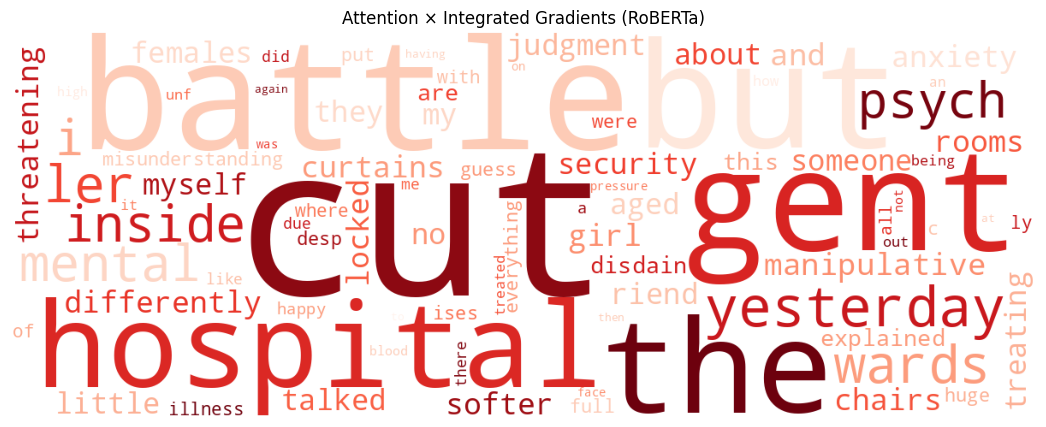

 Saved: /content/drive/MyDrive/ig_outputs/fused_attention_ig_roberta_20260123_190812.png


In [117]:
word_scores_fused = (
    df_fused
    .groupby("token")["fused"]
    .mean()
    .to_dict()
)

word_scores_fused = {
    w: v for w, v in word_scores_fused.items()
    if abs(v) > 1e-4
}

plot_and_save_fused_wordcloud(
    word_scores_fused,
    title="Attention × Integrated Gradients (RoBERTa)",
    filename="fused_attention_ig_roberta"
)
